In [ ]:
# This notebook contains the code for the experiments in Section 6

In [1]:
import numpy as np
from numpy import matlib
import scipy
from scipy import sparse as sp
from scipy.sparse import csr_matrix as csr
from scipy import linalg
from scipy.stats import norm
from scipy.special import hermitenorm as hermite
import math
from scipy.special import binom as newton
import matplotlib.pyplot as plt
import timeit, time

## Tools and functions

In [3]:
# This code construcs the tolls in sparse format

# i-th Euclidean COLUMN vector in R^n (it has 1 in position i-1 since we start counting from 0)
e_Ni_s = lambda N, i: csr.transpose(csr([[1.0 if k == (i-1) else 0.0 for k in range(N)]]))

# Basis COLUMN vector of bivariate monomials of degree N evaluated in z=(y,x) (it's a vector of dim=(N+1)*(N+2)/2)
def H_N_xy_s(N, y, x): 
    H_N_xy = csr([[1]])
    if (N>0):
        for k in range(1,N+1):
            for j in range(k+1):
                H_N_xy = sp.vstack((H_N_xy, [[x**j*y**(k-j)]]))
    return H_N_xy




class poly_process2d_sparse(object):
# Bivariate polynomial diffusion processes
    
    def __init__(self, coeff):
    # coeff is a dictionary of two components:
    # 'B' : 2x3 matrix of the form [[b0, b1, b2], [beta0, beta1, beta2]]
    # 'S' : 2x3 matrix of the form [[sigma0, sigma1, sigma2], [s0, s1, s2]]
        
        self.coeff = coeff
    
    
    def _gen_ym(self, m):
    # case 1 
    # Returns the coefficients of the generator applyed to y**m for m > 1 

        coeff = self.coeff
        b0, b1, b2 = coeff['B'][0,:]
        beta0, beta1, beta2 = coeff['B'][1,:]
        sig0, sig1, sig2 = coeff['S'][0,:]
        s0, s1, s2 = coeff['S'][1,:]
    
        v = csr((1,int((m-2)*(m-1)/2)))
        v = sp.hstack((v, csr([[m*(m-1)*sig0**2/2]]), csr((1,int(m-2)))))
        v = sp.hstack((v, csr([[m*(m-1)*sig0*sig1+m*b0, m*(m-1)*sig0*sig2]]), csr((1,int(m-2)))))
        v = sp.hstack((v, csr([[m*b1+m*(m-1)*sig1**2/2, b2*m+m*(m-1)*sig1*sig2, m*(m-1)*sig2**2/2]]), csr((1,int(m-2)))))
        return v
  

    def _gen_ymx(self, m):
    # case 2 
    # Returns the coefficients of the generator applyed to y**m * x for m > 1 

        coeff = self.coeff    
        b0, b1, b2 = coeff['B'][0,:]
        beta0, beta1, beta2 = coeff['B'][1,:]
        sig0, sig1, sig2 = coeff['S'][0,:]
        s0, s1, s2 = coeff['S'][1,:]
    
        v = csr((1,int(m*(m-1)/2)))
        v = sp.hstack((v, csr([[m*sig0*s0, m*(m-1)*sig0**2/2]]), csr((1,int(m-2)))))
        v = sp.hstack((v, csr([[beta0+m*(s0*sig1+sig0*s1), m*b0+m*(m-1)*sig0*sig1+m*(sig0*s2+sig2*s0), m*(m-1)*sig0*sig2]]), csr((1,int(m-2)))))
        v = sp.hstack((v, csr([[beta1+m*sig1*s1, m*b1+beta2+m*(m-1)*sig1**2/2+m*(sig1*s2+s1*sig2), b2*m+m*(m-1)*sig1*sig2+m*sig2*s2, m*(m-1)*sig2**2/2]]), csr((1,int(m-2)))))
        return v

    
    def _gen_ymxn(self, m, n):
    # case 3
    # Returns the coefficients of the generator applyed to y**m * x**n for m,n > 1 

        coeff = self.coeff    
        b0, b1, b2 = coeff['B'][0,:]
        beta0, beta1, beta2 = coeff['B'][1,:]
        sig0, sig1, sig2 = coeff['S'][0,:]
        s0, s1, s2 = coeff['S'][1,:]
    
        v = csr((1,int((m+n-2)*(m+n-1)/2+n-2)))
        v = sp.hstack((v, csr([[n*(n-1)*s0**2/2, n*m*sig0*s0, m*(m-1)*sig0**2/2]]), csr((1,int(m+n-4)))))
        v = sp.hstack((v, csr([[n*(n-1)*s0*s1, n*(n-1)*s0*s2+n*beta0+n*m*(s0*sig1+sig0*s1), n*m*(sig0*s2+sig2*s0)+sig0*sig1*m*(m-1)+m*b0, m*(m-1)*sig0*sig2]]), csr((1,int(m+n-4)))))
        v = sp.hstack((v, csr([[n*(n-1)*s1**2/2, n*(n-1)*s1*s2+n*m*sig1*s1+beta1*n, m*b1+beta2*n+m*(m-1)*sig1**2/2+n*m*(sig1*s2+s1*sig2)+n*(n-1)*s2**2/2, b2*m+m*(m-1)*sig1*sig2+n*m*sig2*s2, m*(m-1)*sig2**2/2]]), csr((1,int(m-2)))))
        return v
    
    
    def _gen_xny(self, n):
    # case 4
    # Returns the coefficients of the generator applyed to y * x**n for n > 1 
    
        coeff = self.coeff    
        b0, b1, b2 = coeff['B'][0,:]
        beta0, beta1, beta2 = coeff['B'][1,:]
        sig0, sig1, sig2 = coeff['S'][0,:]
        s0, s1, s2 = coeff['S'][1,:]
    
        v = csr((1,int(n*(n+1)/2-2)))
        v = sp.hstack((v, csr([[n*(n-1)*s0**2/2, n*sig0*s0]]), csr((1,int(n-2)))))
        v = sp.hstack((v, csr([[n*(n-1)*s0*s1, n*(n-1)*s0*s2+n*beta0+n*(s0*sig1+sig0*s1), b0+n*(sig0*s2+sig2*s0)]]), csr((1,int(n-2)))))
        v = sp.hstack((v, csr([[n*(n-1)*s1**2/2, n*beta1+n*(n-1)*s1*s2+n*sig1*s1, b1+beta2*n+n*(n-1)*s2**2/2+n*(sig1*s2+sig2*s1), b2+n*sig2*s2]])))
        return v
    
    
    def _gen_xn(self, n):
    # case 5
    # Returns the coefficients of the generator applyed to x**n for n > 1 

        coeff = self.coeff        
        b0, b1, b2 = coeff['B'][0,:]
        beta0, beta1, beta2 = coeff['B'][1,:]
        sig0, sig1, sig2 = coeff['S'][0,:]
        s0, s1, s2 = coeff['S'][1,:]
    
        v = csr((1,int(n*(n-1)/2-1)))
        v = sp.hstack((v, csr([[n*(n-1)*s0**2/2]]), csr((1,int(n-2)))))
        v = sp.hstack((v, csr([[n*(n-1)*s0*s1, n*(n-1)*s0*s2+n*beta0]]), csr((1,int(n-2)))))
        v = sp.hstack((v, csr([[n*(n-1)*s1**2/2, n*beta1+n*(n-1)*s1*s2, beta2*n+n*(n-1)*s2**2/2]])))
        return v
    
    
    def _new_block(self, k):
    # Returns the new block of order k when constrcuting the generator matrix

        coeff = self.coeff    
        block =  self._gen_ym(k)
        block = sp.vstack((block,  self._gen_ymx(k-1)))
        for j in np.arange(k-2, 1, -1):
            block = sp.vstack((block,  self._gen_ymxn(j,k-j)))
        block = sp.vstack((block,  self._gen_xny(k-1)))
        block = sp.vstack((block,  self._gen_xn(k)))
        return block

    
    def generator_matrix2d(self, N):
    # Generator matrix of order N for a 2-dim. polynomial diffusion
        
        coeff = self.coeff        
        if N == 0: return csr([[0]])
    
        else:
            b0, b1, b2 = coeff['B'][0,:]
            beta0, beta1, beta2 = coeff['B'][1,:]
            sig0, sig1, sig2 = coeff['S'][0,:]
            s0, s1, s2 = coeff['S'][1,:]

            G = csr([[0, 0, 0], [b0, b1, b2], [beta0, beta1, beta2]])
        
            if (N>1):
                new_blockG = sp.vstack((self._gen_ym(2),
                                       csr([[sig0*s0, s0*sig1+sig0*s1+beta0, sig0*s2+sig2*s0+b0, beta1+sig1*s1, sig1*s2+sig2*s1+beta2+b1, sig2*s2+b2]]),
                                        self._gen_xn(2)))
                G = sp.vstack((sp.hstack((G, csr((3,3)))), new_blockG))
                if (N>2):
                    for k in range(3,N+1):
                        G = sp.vstack((sp.hstack((G, csr((G.shape[0],k+1)))),  self._new_block(k)))
            return G
        
    def exp_generator_matrix2d(self, N, t=1):
        G = self.generator_matrix2d(N)
        expG = sp.linalg.expm((G.tocsc())*t).tocsr()
        return expG



### Model characteristics ### 

In [4]:
r = 0.05
sigma = 0.5
T = 2.0
Y_0 = 2.0
X_0 = 0.0
print('r, sigma, T, Y_0 = ', r, ',', sigma,',', T, ',', Y_0)

coeff = {'B': np.array([[0.0, r, 0.0],[0.0, 1, 0.0]]), 'S': np.array([[0.0, sigma, 0.0],[0.0, 0.0, 0.0]])}

Z = poly_process2d_sparse(coeff)

r, sigma, T, Y_0 =  0.05 , 0.5 , 2.0 , 2.0


In [6]:
order = 1
D = int((order+1)*(order+2)/2)
mean = (e_Ni_s(D,D).transpose()).dot(Z.exp_generator_matrix2d(order, t=T)).dot(H_N_xy_s(order, Y_0, X_0))[0,0]/T

order = 2
D = int((order+1)*(order+2)/2)
std = (e_Ni_s(D,D).transpose()).dot(Z.exp_generator_matrix2d(order, t=T)).dot(H_N_xy_s(order, Y_0, X_0))[0,0]/(T**2)-mean**2
std = np.sqrt(std)

cv = std/mean # coefficient of variation

print('mean = ', mean)
print('std = ', std)
print('cv = ', cv)

mean =  2.103418361512953
std =  0.9286643635281677
cv =  0.44150245168545327


## PRICING

In [7]:
# Preliminary calculations for the Hermite series
# This does not depend on the strike price

N_trunc = 50
expG_N = Z.exp_generator_matrix2d(N = N_trunc, t = T)

H_N = np.zeros(N_trunc+1) 
H_N[0] = 1
for n in range(1,N_trunc+1):
    print('---------------- n = ', n)
    D = int((n+1)*(n+2)/2)
    expG = csr(expG_N.toarray()[:D,:D])
    H_N[n] = e_Ni_s(D,D).transpose().dot(expG).dot(H_N_xy_s(n, Y_0, X_0))[0,0]/(T**n)

print('H_N = ', H_N)

---------------- n =  1
---------------- n =  2
---------------- n =  3
---------------- n =  4
---------------- n =  5
---------------- n =  6
---------------- n =  7
---------------- n =  8
---------------- n =  9
---------------- n =  10
---------------- n =  11
---------------- n =  12
---------------- n =  13
---------------- n =  14
---------------- n =  15
---------------- n =  16
---------------- n =  17
---------------- n =  18
---------------- n =  19
---------------- n =  20
---------------- n =  21
---------------- n =  22
---------------- n =  23
---------------- n =  24
---------------- n =  25
---------------- n =  26
---------------- n =  27
---------------- n =  28
---------------- n =  29
---------------- n =  30
---------------- n =  31
---------------- n =  32
---------------- n =  33
---------------- n =  34
---------------- n =  35
---------------- n =  36
---------------- n =  37
---------------- n =  38
---------------- n =  39
---------------- n =  40
---------

In [9]:
# strike price
K = 2.0

In [10]:
# Parameters for the Hermite series 
min_scale = std/np.sqrt(2) #\underline{b}_{\sigma}
print('min_scale = ', min_scale)

drift = mean
scale = min_scale*2
ratio = (K-drift)/scale

print('K = ', K)
print('drift = ', drift)
print('scale = ', scale)
print('ratio = ', ratio)

min_scale =  0.6566648688970564
K =  2.0
drift =  2.103418361512953
scale =  1.3133297377941129
ratio =  -0.07874516089665026


In [11]:
E_N = np.zeros(N_trunc+1) 
E_N[0] = 1
for j in range(1, N_trunc+1):
    E_N_j = 0
    for i in range(j+1):
        E_N_j += float(newton(j,i))*H_N[i]*((-drift)**(j-i))
    E_N[j] = E_N_j/(scale**(j))

k =  1 , price =  0.5223405042437624
k =  2 , price =  0.5223405042437624
k =  3 , price =  0.40418664330332066
k =  4 , price =  0.4002762732529833
k =  5 , price =  0.35405709687168274
k =  6 , price =  0.35740736634800907
k =  7 , price =  0.4200258139743424
k =  8 , price =  0.3810406183052084
------> Accuracy 10**(-3) for k =  6  ,  1.1796400142282784
k =  9 , price =  -0.3622855507985481
k =  10 , price =  0.4124280905976764
k =  11 , price =  22.730697681694902
k =  12 , price =  -24.050849129705473
k =  13 , price =  -2204.384351808769
k =  14 , price =  7382.097285698359
k =  15 , price =  804701.7459008751
k =  16 , price =  -6984862.773015733
k =  17 , price =  -1262294092.5961342
k =  18 , price =  27327399147.619568
k =  19 , price =  9517332057313.875
k =  20 , price =  -511379666177672.0
k =  21 , price =  -3.721116845939871e+17
k =  22 , price =  4.984873058776252e+19
k =  23 , price =  7.935318486470508e+22
k =  24 , price =  -2.667758606952406e+25
k =  25 , price =  -

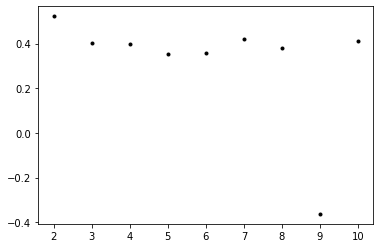

In [14]:
# We now calculate the option price via Hermite series Eq. (4.5)
# We calculate the accuracy accordingly to Eq. (5.9) 

Hprice = np.ones(N_trunc+1)*(scale*norm.pdf(ratio)+(mean-K)*(1-norm.cdf(ratio)))*np.exp(-r*T)
notachieved = 1
best_n = -10
best = 0
print('k = ', 1, ', price = ', Hprice[0])

for k in range(2,N_trunc+1):
    v_k = hermite(k).c[::-1]
    Hprice[k:] += scale*norm.pdf(ratio)*(hermite(k-2)(ratio)/float(math.factorial(k))*v_k.dot(E_N[:(k+1)]))*np.exp(-r*T)
    print('k = ', k, ', price = ', Hprice[k-1])
    if (np.abs(Hprice[k-1]) < 1.5): plt.plot(k, Hprice[k-1], 'k.')
    if (k>3):
        if (-np.log10(abs((Hprice[k-3]-Hprice[k-1])/Hprice[k-3]))>1) and notachieved:
            notachieved = 0
            best = Hprice[k-3]
            best_n = k-2
            print('------> Accuracy 10**(-3) for k = ', k-2, ' , ', -np.log10(abs((Hprice[k-3]-Hprice[k-1])/Hprice[k-3])))

